In [1]:
import numpy as np
import matplotlib.pyplot as plt

Use the triangluar transport map $T:\mathbb{R}^2 \to \mathbb{R}^2$ defined by
$$
T(x_1,x_2) = \begin{bmatrix}
T_1(x_1)\\
T_2(x_1,x_2)
\end{bmatrix}
= \begin{bmatrix}
w_0 + w_1 x_1 + w_2 x_1^2\\
w_3 + w_4 x_1 + w_5 x_2 + w_6 x_1 x_2 + w_7 x_1^2 + w_8 x_2^2
\end{bmatrix}
$$

There are 9 total parameters to optimize over.

In [15]:
# Define the quadratic map.
def T(x, w):
    x1 = x[0]
    x2 = x[1]
    T1 = w[0] + w[1]*x1 + w[2]*x1**2
    T2 = w[3] + w[4]*x1 + w[5]*x2 + w[6]*x1*x2 + w[7]*x1**2 + w[8]*x2**2
    return np.array([T1, T2])

# Inverse of the map.
def T_inv(y, w):
    y1 = y[0]
    y2 = y[1]
    x1 = (-w[1] + np.sqrt(w[1]**2 - 4*w[2]*(w[0] - y1)))/(2*w[2])
    a = w[8]
    b = w[6]*x1 + w[5]
    c = w[7]*x1**2 + w[4]*x1 + w[3] - y2
    x2 = (-b + np.sqrt(b**2 - 4*a*c))/(2*a)
    return np.array([x1, x2])

# Returns the Jacobian matrix.
def T_grad(x, w):
    x1 = x[0]
    x2 = x[1]
    g11 = w[1] + 2*w[2]*x1
    g12 = 0
    g21 = w[4] + w[6]*x2 + 2*w[7]*x1
    g22 = w[5] + w[6]*x1 + 2*w[8]*x2
    return np.array([[g11, g12], [g21, g22]])

# Returns Jacobian of inverse.
def T_inv_grad(y, w):
    return np.linalg.inv(T_grad(T_inv(y, w), w))

Transporting i.i.d. $N(0, I)$ samples with different choices of $\vec{w}$.

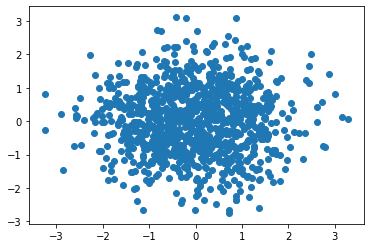

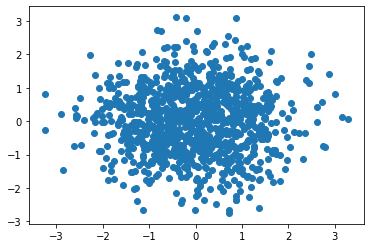

In [16]:
# Random samples
X = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000).T

w = [0, 10, 1, 1, 1, 10, 0, 1, 1]

Tx = T_inv(T(X, w), w)

plt.figure(1)
plt.scatter(X[0,:], X[1,:])
plt.figure(2)
plt.scatter(Tx[0,:], Tx[1,:])

Define the target and reference densities.

In [55]:
# Target density is un-normalized.
def p(x):
    x1 = x[0]
    x2 = x[1]
    V = 10*(x2 - x1**2)**2 + (x1-1)**2
    return np.exp(-V)

# Reference density is standard normal.
def b(x):
    x1 = x[0]
    x2 = x[1]
    V = 0.5*(x1**2 + x2**2) + np.log(2*np.pi)
    return np.exp(-V)

# Function to sample the reference distribution.
def sample_ref(N):
    return np.random.multivariate_normal(np.zeros(2), np.eye(2), N).T

Define the $\chi^2$ objective function between $p$ and the pushforward measure $q = T_{\#}b$
$$
D(\vec{w}) = \frac{1}{N}\sum_{i=1}^N \left( \frac{p(T(x_i))}{q(T(x_i))} \right)^2
$$
where $x_i \sim b$ are i.i.d. samples.  The dependence on $\vec{w}$ is through $T$ and also $q$.  The derivative w.r.t. $\vec{w}$ is
$$
\nabla_{\vec{w}} D(\vec{w}) = \frac{2}{N} \sum_{i=1}^N \left( \frac{p(T(x_i))}{q(T(x_i))} \right) \nabla_{\vec{w}}\left( \frac{p(T(x_i))}{q(T(x_i))} \right)
$$
The pushforward density is $q(x) = T_{\#}b(x) = b(T^{-1}(x))|\det \nabla_x T^{-1}(x)|$ so
$$
q(x) = b(T^{-1}(x)) \left| \det \left( \nabla_x T(T^{-1}(x)) \right)^{-1} \right| = \frac{b(T^{-1}(x))}{|\det \nabla_x T(T^{-1}(x))|}
$$
and 
$$
q(T(x)) = \frac{b(x)}{|\det \nabla_x T(x)|}
$$

In [51]:
# Helper method to vectorize computation of determinants.
def grad_det(X, w):
    N = X.shape[1]
    gd = np.zeros(N)
    for i in range(N):
        gd[i] = np.abs(np.linalg.det(T_grad(X[:,i], w)))
    return gd

def D(w, X):
    N = X.shape[1] # Number of columns/samples
    likeli = p(T(X, w))*grad_det(X, w)/(b(X))
    return np.mean(likeli**2)

def grad_D(w, X):
    h = 1e-4
    d = len(w)
    g = np.zeros(d) # The gradient of finite differences.
    
    for i in range(d):
        e = np.zeros(d)
        e[i] = 1.0 # Unit basis vector.
        g[i] = (D(w + h*e, X) - D(w - h*e, X))/(2*h)
    
    return g

In [52]:
def minimize_chisq(w0, X):
    w = w0
    
    for i in range(500):
        g = grad_D(w, X)
        if np.mod(i,50) == 0:
            print(np.linalg.norm(g))
        w -= 5e-4 * g/(i+1) # Update with decaying learning rate
    return w

In [ ]:
X = sample_ref(100)

In [67]:
w = minimize_chisq(w, X)
print(w)

7.538590920591939
7.473096618135325
7.4632904867150085
7.457560457925386
7.453500716602377
7.450355786146546
7.4477890929892245
7.445621146814846
7.443744852994588
7.442091166291085
[-0.38182982 -2.65971505 -0.33567441  1.83186034  1.00565878  1.30805438
  0.72617446  1.64919876 -0.05610015]


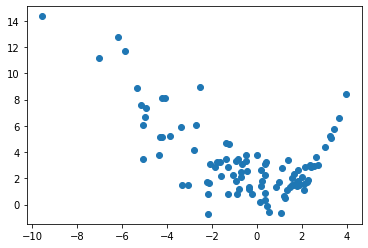

In [68]:
Tx = T(X, w)

plt.scatter(Tx[0], Tx[1])